In [1]:
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_device", jax.devices()[2])

import jax.numpy as jnp
from KernelTools import make_block,eval_k,vectorize_kfunc,diagpart,get_selected_grad
from Kernels import get_gaussianRBF,get_centered_scaled_poly_kernel
from data_utils import build_xy_grid
from darcy_data import get_darcy_solver,sample_gp_function
from jax.random import PRNGKey as pkey
import matplotlib.pyplot as plt
from EquationModel import CholInducedRKHS,OperatorPDEModel,InducedOperatorModel
from tqdm.auto import tqdm

In [2]:
num_functions = 60
samples_per_function = 10
obs_random_keys = jax.random.split(pkey(32),num_functions)
xy_obs = tuple(jax.random.uniform(key,(samples_per_function,2),minval = 0.,maxval = 1.) for key in obs_random_keys)


kernel_f = get_gaussianRBF(0.15)
key = pkey(10)
keys = jax.random.split(key,num_functions)
rhs_functions = tuple(
    sample_gp_function(subkey,kernel_f) for subkey in keys
)

grid = jnp.linspace(0,1,100)
x,y = jnp.meshgrid(grid,grid)
fine_grid = jnp.vstack([x.flatten(),y.flatten()]).T

def a(x):
    return 0.1 * jnp.exp(0.5 * jnp.sin(4*jnp.pi*x[0]*x[1]))

darcy_solve = get_darcy_solver(a,num_grid = 50,k_u = get_gaussianRBF(0.2))
u_true_functions = tuple([darcy_solve(f) for f in rhs_functions])

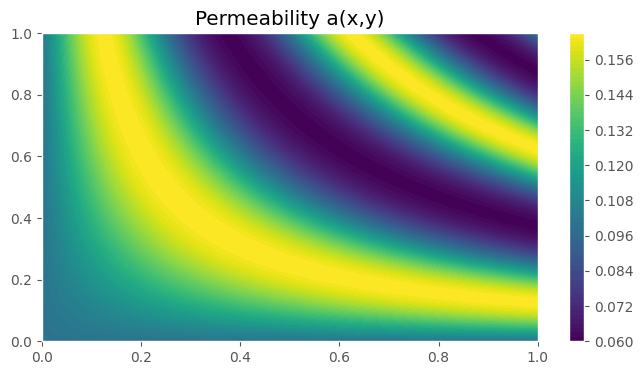

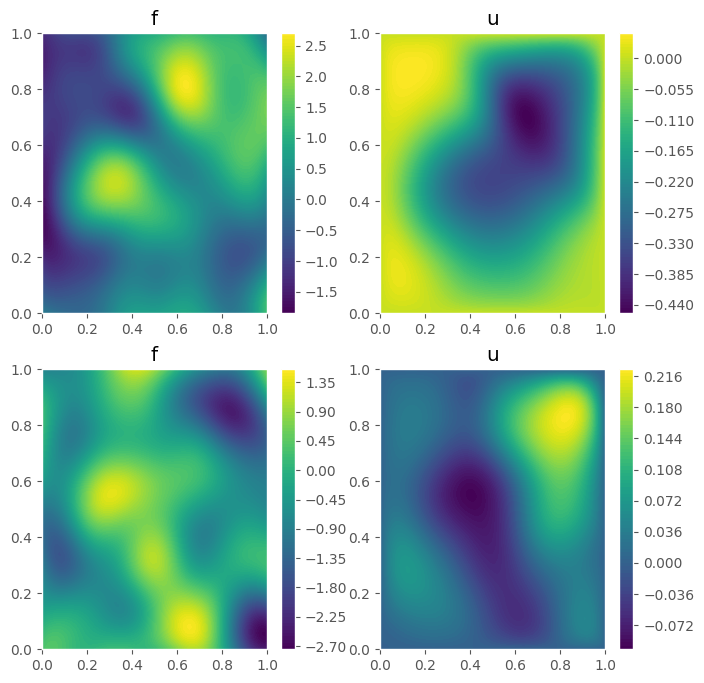

In [4]:
num_to_plot = 2
plt.figure(figsize=(8,4))
plt.title("Permeability a(x,y)")
plt.tricontourf(fine_grid[:,0],fine_grid[:,1],jax.vmap(a)(fine_grid),100)
plt.colorbar()
plt.show()
plt.figure(figsize = (8,num_to_plot * 4))
for i in range(num_to_plot):
    plt.subplot(num_to_plot,2,2*i+1)
    plt.title("f")
    plt.tricontourf(fine_grid[:,0],fine_grid[:,1],jax.vmap(rhs_functions[i])(fine_grid),100)
    plt.colorbar()
    plt.subplot(num_to_plot,2,2*(i+1))
    plt.title('u')
    plt.tricontourf(fine_grid[:,0],fine_grid[:,1],jax.vmap(u_true_functions[i])(fine_grid),100)
    plt.colorbar()
plt.show()

In [5]:
k_u = get_gaussianRBF(0.2)
xy_int,xy_bdy=build_xy_grid([0,1],[0,1],25,25)
xy_all = jnp.vstack([xy_int,xy_bdy])


# plt.title('u')
# plt.tricontourf(fine_grid[:,0],fine_grid[:,1],jax.vmap(u_true_functions[0])(fine_grid),100)
# plt.colorbar()
# plt.scatter(xy_int[:,0],xy_int[:,1],c = 'black',s = 3)
# plt.scatter(xy_obs[:,0],xy_obs[:,1],c = 'red',s = 50,alpha = 0.8)
# plt.show()

In [6]:
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])
basis_operators = tuple([eval_k,diff_xx_op,diff_yy_op])

u_models = tuple([CholInducedRKHS(
    xy_all,
    basis_operators,
    k_u
    ) for i in range(num_functions)])


observation_points = tuple(jnp.vstack([xy_bdy,obs]) for obs in xy_obs)
observation_values = tuple(jax.vmap(u)(obs_loc) for u,obs_loc in zip(u_true_functions,observation_points))
collocation_points = (xy_int,)*num_functions

rhs_values = tuple(jax.vmap(rhs_func)(int_points) for rhs_func,int_points in zip(rhs_functions,collocation_points))

all_u_params_init = tuple([
    model.get_fitted_params(obs_loc,obs_val) 
    for obs_loc,obs_val,model in zip(observation_points,observation_values,u_models)
    ]
    )

grid_features_u_init = [(
    model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for model,model_params in zip(u_models,all_u_params_init)
        ]
grid_features_u_init = jnp.vstack([jnp.hstack([xy_int,features]) for features in grid_features_u_init])

num_P_inducing = 250
input_feature_sample = jax.random.choice(pkey(320),grid_features_u_init,(num_P_inducing,))
k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
k_P_x_part = get_gaussianRBF(0.25)
def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])

P_model = InducedOperatorModel(input_feature_sample,k_P)
P_init = P_model.get_fitted_params(grid_features_u_init,jnp.hstack(rhs_values),lam = 1e-6)

In [7]:
params_init = jnp.hstack(list(all_u_params_init)+[P_init])
EqnModel  = OperatorPDEModel(
    P_model,
    u_models,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_values,
    datafit_weight = 20.,
    num_P_operator_params=250
)

In [8]:
from jaxopt import LBFGS

def run_jax_solver(solver, x0):
    state = solver.init_state(x0)
    sol = x0
    values, errors, stepsizes = [state.value], [state.error], [state.stepsize]

    def update(sol, state):
        return solver.update(sol, state)

    jitted_update = jax.jit(update)
    for iter_num in tqdm(range(solver.maxiter)):
        sol, state = jitted_update(sol, state)
        values.append(state.value)
        errors.append(state.error)
        stepsizes.append(state.stepsize)
        if solver.verbose > 0:
            print("Gradient Norm: ", state.error)
            print("Loss Value: ", state.value)
        if state.error <= solver.tol:
            break
        if stepsizes[-1] == 0:
            print("Restart")
            state = solver.init_state(sol)
    convergence_data = {
        "values": jnp.array(values),
        "gradnorms": jnp.array(errors),
        "stepsizes": jnp.array(stepsizes),
    }
    return sol, convergence_data, state

In [10]:
jit_valgrad = jax.jit(jax.value_and_grad(EqnModel.loss))

m_init = 0 * params_init
gamma = 0.7

@jax.jit
def scan_fn(carry, _):
    params, m = carry
    loss_val, g = jit_valgrad(params)
    m_new = (1 - gamma) * m + gamma * g
    d = g + m_new
    params_new = params - (6e-3) * d
    carry_new = (params_new, m_new)
    return carry_new, loss_val  # loss_val will be collected in the output

# Run the scan over 1000 iterations
(carry_final, losses) = jax.lax.scan(
    scan_fn,
    init=(params_init, m_init),
    xs=None,
    length=1000
)

params_final, m_final = carry_final


In [11]:
jit_valgrad = jax.jit(jax.value_and_grad(EqnModel.loss))
lbfgs = LBFGS(fun=jit_valgrad,value_and_grad = True, maxiter=5000,tol = 1e-6,history_size = 40)
lbfgs_sol,lbfgs_conv,state = run_jax_solver(lbfgs,params_init)

  0%|          | 0/5000 [00:00<?, ?it/s]

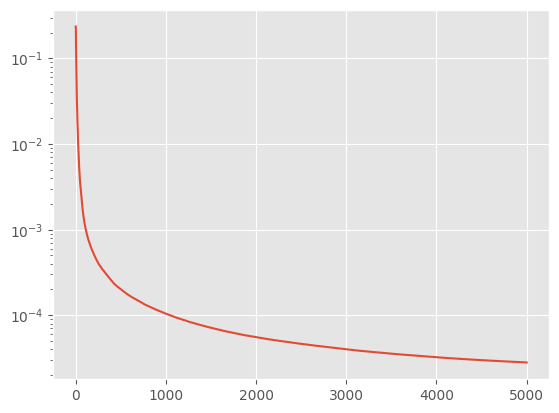

In [12]:
plt.style.use('ggplot')
plt.plot(lbfgs_conv['values'])
#plt.plot(losses)
plt.yscale('log')

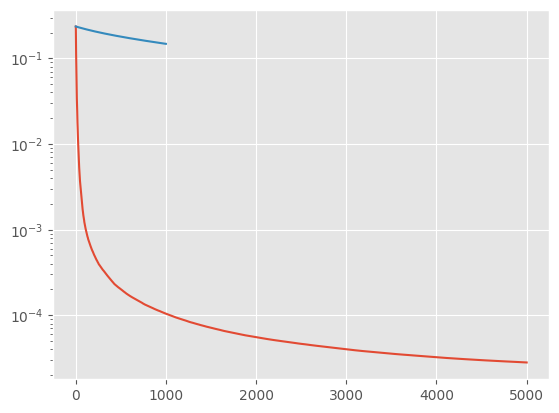

In [13]:
plt.style.use('ggplot')
plt.plot(lbfgs_conv['values'])
plt.plot(losses)
plt.yscale('log')

In [14]:
P_params = EqnModel.get_P_params(lbfgs_sol)
u_params = EqnModel.get_u_params(lbfgs_sol)

In [15]:
def build_darcy_op(a):
    def darcy_op(k,index):
        gradk = jax.grad(k,argnums = index)
        def agradk(*args):
            return a(args[index])*gradk(*args)
        def darcy_result(*args):
            return jnp.trace(jax.jacfwd(agradk,argnums = index)(*args))
        return darcy_result
    return darcy_op
darcy_op = build_darcy_op(a)

In [16]:
grid = jnp.linspace(0.0001,0.999,50)
x,y = jnp.meshgrid(grid,grid)
fine_grid_int = jnp.vstack([x.flatten(),y.flatten()]).T

In [17]:
eqnFeatures = EqnModel.single_eqn_features(u_models[0],u_params[0],fine_grid_int)
Phat_uhat = P_model.predict(eqnFeatures,P_params)

2024-11-01 13:44:34.798142: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce.9 = f64[2500,625]{1,0} reduce(f64[2500,625,2]{2,1,0} %broadcast.962, f64[] %constant.56), dimensions={2}, to_apply=%region_9.115, metadata={op_name="jit(single_eqn_features)/jit(main)/jit(evaluate_operators)/reduce_sum" source_file="/home/owlx/kernelequationlearning/keql_tools/Kernels.py" source_line=37}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-11-01 13:44:37.531934: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 3.733919015s
Constant folding an instruction is 

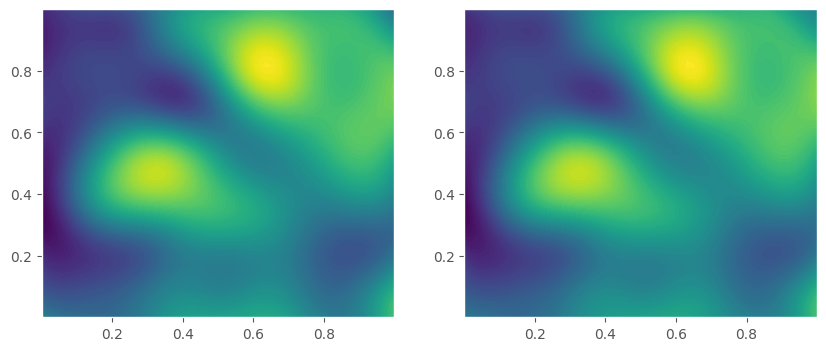

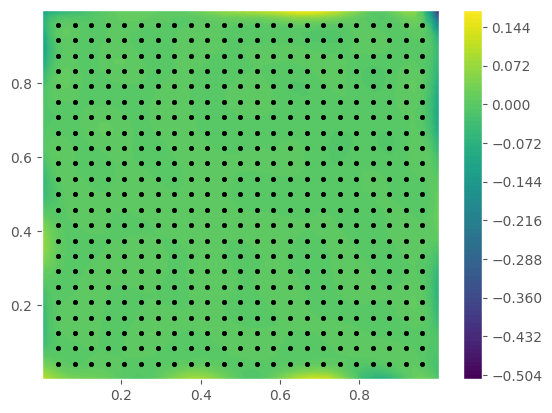

In [18]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.tricontourf(fine_grid_int[:,0],fine_grid_int[:,1],jax.vmap(rhs_functions[0])(fine_grid_int),100)
plt.subplot(1,2,2)
plt.tricontourf(fine_grid_int[:,0],fine_grid_int[:,1],Phat_uhat,100)
plt.show()
plt.tricontourf(fine_grid_int[:,0],fine_grid_int[:,1],jax.vmap(rhs_functions[0])(fine_grid_int) - Phat_uhat,100)
plt.colorbar()
plt.scatter(xy_int[:,0],xy_int[:,1],c = 'black',s = 10)
plt.show()

In [19]:
jnp.linalg.norm(jax.vmap(rhs_functions[0])(fine_grid_int) - Phat_uhat)/jnp.linalg.norm(jax.vmap(rhs_functions[0])(fine_grid_int))

Array(0.0232466, dtype=float64)

In [20]:
percent_errors = []
for i in range(num_functions):
    u_vals = u_models[i].point_evaluate(fine_grid_int,u_params[i])
    u_true_vals = jax.vmap(u_true_functions[i])(fine_grid_int)
    percent_errors.append(jnp.linalg.norm(u_vals - u_true_vals)/jnp.linalg.norm(u_true_vals))

In [21]:
jnp.mean(jnp.array(percent_errors))

Array(0.04044952, dtype=float64)

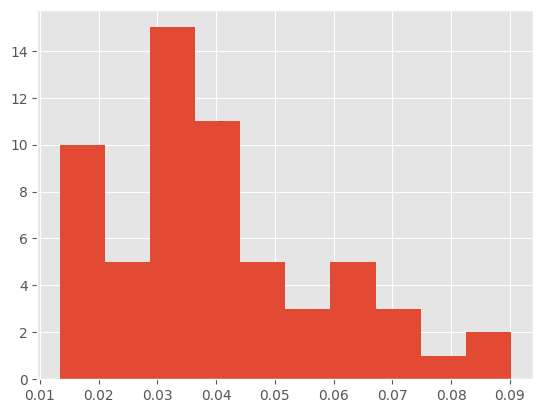

In [22]:
plt.hist(percent_errors,10)
plt.show()

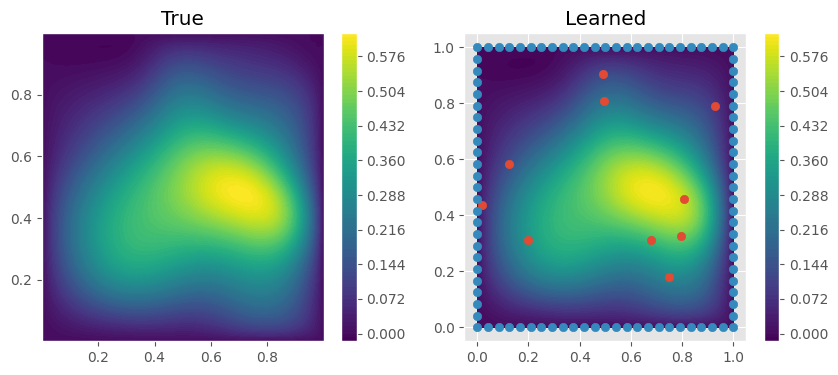

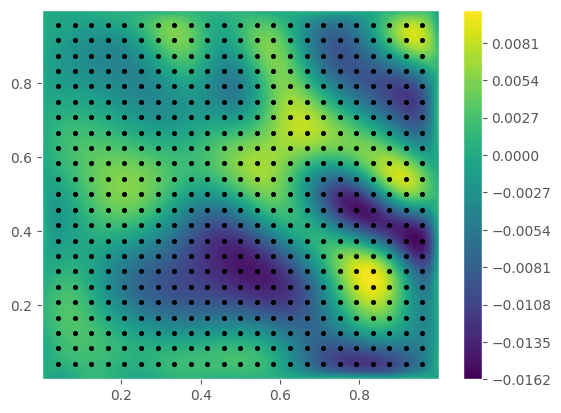

In [25]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.tricontourf(fine_grid_int[:,0],fine_grid_int[:,1],u_true_vals,100)
plt.colorbar()
plt.title("True")
plt.subplot(1,2,2)
plt.tricontourf(fine_grid_int[:,0],fine_grid_int[:,1],u_vals,100)
plt.colorbar()
plt.title("Learned")
plt.scatter(xy_obs[-1][:,0],xy_obs[-1][:,1])
plt.scatter(xy_bdy[:,0],xy_bdy[:,1])
plt.show()
plt.tricontourf(fine_grid_int[:,0],fine_grid_int[:,1],u_vals - u_true_vals,100)
plt.colorbar()
plt.scatter(xy_int[:,0],xy_int[:,1],c = 'black',s = 10)


In [34]:
def get_feature_map(f):
    def f_feats(x):
        f_ops = jnp.array([op(f,0)(x) for op in feature_operators])
        return jnp.hstack([x,f_ops])
    return f_feats

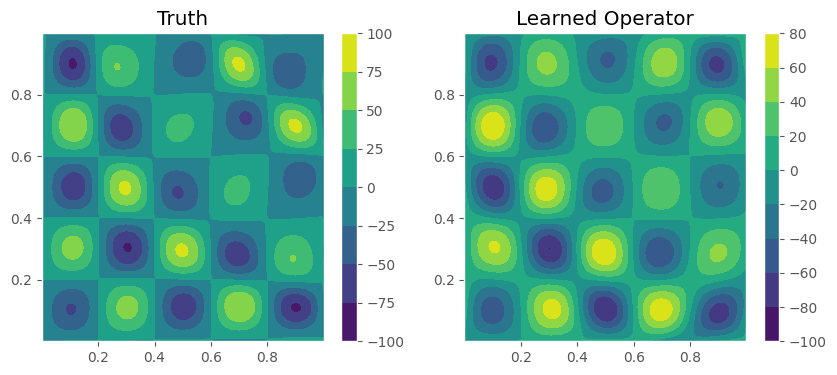

In [56]:
grid = jnp.linspace(0.0001,0.999,200)
x,y = jnp.meshgrid(grid,grid)
fine_grid_int = jnp.vstack([x.flatten(),y.flatten()]).T

def new_func(x):
    return jnp.sin(5*jnp.pi*x[0])*jnp.sin(5*jnp.pi*x[1])

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
vals = jax.vmap(darcy_op(new_func,0))(fine_grid_int)
plt.tricontourf(fine_grid_int[:,0],fine_grid_int[:,1],vals)
plt.colorbar()
plt.title("Truth")
new_feats = jax.vmap(get_feature_map(new_func))(fine_grid_int)
pred_op = P_model.predict(new_feats,P_params)
plt.subplot(1,2,2)
plt.tricontourf(fine_grid_int[:,0],fine_grid_int[:,1],pred_op)
plt.colorbar()
plt.title("Learned Operator")
plt.show()

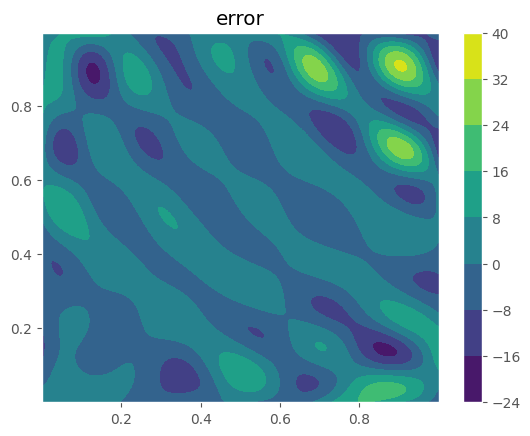

In [57]:
plt.tricontourf(fine_grid_int[:,0],fine_grid_int[:,1],vals - pred_op)
plt.title("error")
plt.colorbar()
plt.show()

In [58]:
jnp.linalg.norm(vals - pred_op)/jnp.linalg.norm(vals)

Array(0.22278948, dtype=float64)